In [4]:
import os
from astropy.io import fits
from astropy.table import Table
import astropy.wcs as wcs
import astropy.units as u
from astropy.convolution import Gaussian2DKernel, convolve, convolve_fft, interpolate_replace_nans
from astropy.stats import mad_std
import numpy as np
from radio_beam import Beam
from scipy.ndimage.morphology import binary_dilation, binary_closing
from reproject import reproject_interp
from matplotlib import pyplot as plt
from astropy.stats import SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from photutils.background import Background2D
from matplotlib import colors 
import glob
from astropy.wcs import WCS
import regions
from mpl_toolkits.axes_grid1 import make_axes_locatable

from reduction_phangs_hst import contsub, contsub_misc, contsub_postprocess, contsub_postprocess_cosmicrays, contsub_postprocess_cosmicraysnnet

/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_84080/2845325847.py:10: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation, binary_closing
/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_84080/2845325847.py:10: DeprecationWarning: Please use `binary_closing` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation, binary_closing


In [2]:
rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data/ngc628c/hst_contsub/f658n_f555w_f814w/'

In [5]:
hdu_hst = fits.open(rootdir+'ngc628c_halpha.fits')[0]
hdu_muse = fits.open(rootdir+'ngc628c_musehalpha.fits')[0]

input_muse_filename = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data/ngc628c/muse/NGC0628-0.92asec_MAPS.fits'

initial_resolution = 0.1 * u.arcsec
desired_resolution = float(contsub_misc.extract_substring(input_muse_filename, pattern=r'\d+\.\d+')) * u.arcsec
hdu_hst_smoothed   = contsub_postprocess.smooth_image_with_beam(hdu_hst, initial_resolution, desired_resolution, 
                                                                    output_filename = rootdir+'ngc628c_halpha_smoothed.fits')

hdu_hst_bgsub_smoothed_regrid = contsub_postprocess.regrid(hdu_hst_smoothed, hdu_muse, 
                                                           output_filename = rootdir+'ngc628c_halpha_smoothed_regrid.fits')

[INFO] Smoothing the image with a beam kernel...
[INFO] Pixel scale: 0.04 arcsec arcsec
[INFO] Initial Resolution: 0.10 arcsec arcsec
[INFO] Desired Resolution: 0.92 arcsec arcsec
[INFO] Convolution kernel: 0.91 arcsec arcsec
[INFO] Performing image convolution...
[INFO] Image convolution complete.
[INFO] Saving the smoothed image to: /Users/abarnes/Dropbox/work/Smallprojects/galaxies/data/ngc628c/hst_contsub/f658n_f555w_f814w/ngc628c_halpha_smoothed.fits
[INFO] Image saved successfully.
[INFO] Smoothing process completed.
[INFO] Reprojecting the input image to match the template WCS...
[INFO] Performing image reprojection...
[INFO] Image reprojection complete.
[INFO] Scaling the output data to conserve flux with factor 25.48
[INFO] Flux scaling complete.
[INFO] Saving the reprojected image to: /Users/abarnes/Dropbox/work/Smallprojects/galaxies/data/ngc628c/hst_contsub/f658n_f555w_f814w/ngc628c_halpha_smoothed_regrid.fits
[INFO] Image saved successfully.
[INFO] Reprojection process com

[INFO] MUSE mask lims: 25.0 24363.0
[INFO] HST mask lims: -268.8 16159.5
[INFO] xy-fit --- slope: 0.5874077770602377, intercept: -144.51821076682992
[INFO] xy-fit scaled --- slope: 0.5874077770602377, intercept: -5.671416301230864


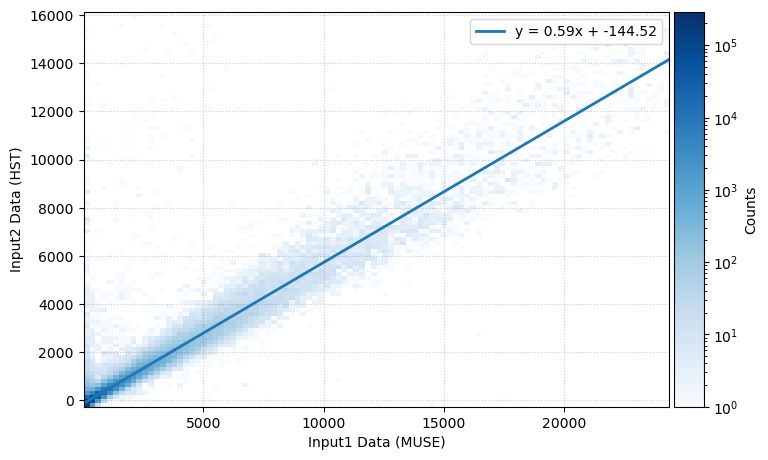

In [6]:
hdu_input1 = fits.open(rootdir+'ngc628c_musehalpha.fits')[0]
hdu_input2 = fits.open(rootdir+'ngc628c_halpha_smoothed_regrid.fits')[0]
hdu_input3 = fits.open(rootdir+'ngc628c_halpha.fits')[0]

output_filename = rootdir+'ngc628c_halpha_fit_anchored_musegrid.fits'

rootdir = os.path.dirname(output_filename)

valid_indices = np.isfinite(hdu_input1.data) & np.isfinite(hdu_input2.data)
x_data = hdu_input1.data[valid_indices]
y_data = hdu_input2.data[valid_indices]

xpmin = 0.1
ypmin = 0.1
xpmax = 99.9
ypmax = 99.9

x_minmask, x_maxmask = np.nanpercentile(x_data,xpmin), np.nanpercentile(x_data,xpmax)
y_minmask, y_maxmask = np.nanpercentile(y_data,ypmin), np.nanpercentile(y_data,ypmax)

print(f"[INFO] MUSE mask lims: %0.1f %0.1f" %(x_minmask, x_maxmask))
print(f"[INFO] HST mask lims: %0.1f %0.1f" %(y_minmask, y_maxmask))
x_mask = ((x_data>x_minmask) & (x_data<x_maxmask))
y_mask = ((y_data>y_minmask) & (y_data<y_maxmask))

x_data = x_data[x_mask&y_mask]
y_data = y_data[x_mask&y_mask]

# Calculate a line of best fit for the data
slope, intercept = np.polyfit(x_data, y_data, 1)
x_fit = np.linspace(np.min(x_data), np.max(x_data), 100)
y_fit = slope * x_fit + intercept
print(f"[INFO] xy-fit --- slope: {slope}, intercept: {intercept}")

# Create a 2D histogram plot using the filtered data
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

hist = ax.hist2d(x_data, y_data, bins=100, cmap='Blues', norm=colors.LogNorm())
ax.plot(x_fit, y_fit, color='C0', linewidth=2, label=f'y = {slope:.2f}x + {intercept:.2f}')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(hist[3], cax=cax, label='Counts')

ax.set_xlabel('Input1 Data (MUSE)')
ax.set_ylabel('Input2 Data (HST)')
ax.legend()
ax.grid(True, ls=':', color='k', alpha=0.2)

fig.savefig(rootdir+'fit.png', bbox_inches='tight')

# Apply the calculated line of best fit to the second input data and save it as a new FITS file

# Extract the WCS information from the input and template headers
wcs_input1 = wcs.WCS(hdu_input1.header)
wcs_input3 = wcs.WCS(hdu_input3.header)
pixscale_input1 = wcs.utils.proj_plane_pixel_area(wcs_input1.celestial)
pixscale_input3 = wcs.utils.proj_plane_pixel_area(wcs_input3.celestial)

pixscale_ratio = (pixscale_input3 / pixscale_input1)
print(f"[INFO] xy-fit scaled --- slope: {slope}, intercept: {intercept*pixscale_ratio}")

hdu_fit_anchored = hdu_input3.copy()
hdu_fit_anchored.data = (hdu_fit_anchored.data - (intercept*pixscale_ratio)) / slope
hdu_fit_anchored.writeto(output_filename, overwrite=True)